### Matrix factorization via NN, contrasting MAE with surpriselib's baseline algos SVD, SVD++

In [1]:
import os
import numpy as np
import pandas as pd


data_path = os.path.expanduser('C:\\Users\\might\\Desktop\\jupyter notebooks\\u.data')

* #### original df containing all 100k data points

In [2]:
df = pd.read_csv(data_path, sep='\t', header=None)
df[2]= df[2].apply(lambda x: int(x>3))#since in df, no. vals holding 1 ratings:6110, 2 ratings:11370, 3 ratings:27145, 4 ratings:34174, 5 ratings: 21201 
df.head(5)#Therefore all ratings(55375) of 4,5 squished to 1 & all ratings(44625) of 1,2,3 are squished to 0

,0,1,2,3
0,196,242,0,881250949
1,186,302,0,891717742
2,22,377,0,878887116
3,244,51,0,880606923
4,166,346,0,886397596


In [3]:
shuffled_df = df.loc[np.random.randint(0, 100000, size=df.shape[0])]

#sm_train_df = shuffled_df[:80000]#small dataframe, trimming data points to random 2000 datapoints
#test_df= shuffled_df[-20000:]

#print('new trimmed dataset:', sm_train_df.shape, '\nnew test dataset:', test_df.shape)
print('shape of dataset:', shuffled_df.shape)

shape of dataset: (100000, 4)


* ### Training & testing results with SVD from surpriselib
    * Using same dataframes for all three
    * n_factors= 100, epochs= 64

In [4]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader

from surprise.model_selection import train_test_split

rdr = Reader(rating_scale=(0,1))
#train_data = Dataset.load_from_df(sm_train_df[[0,1,2]], reader= rdr)
data = Dataset.load_from_df(shuffled_df[[0,1,2]], reader= rdr)

#trainset = train_data.build_full_trainset()#contains 80k data points

trainset, testset = train_test_split(data, test_size=0.2)
#both trainset & testset have their ratings value swapped from 1 in place of 0; and 2 in place of 1

#test_data= Dataset.load_from_df(test_df[[0,1,2]], reader= rdr)
#testset = test_data.build_full_trainset().build_testset()#testset for surprise.SVD

In [5]:
from surprise import accuracy
import time

t1= time.time()

algo_svd = SVD(n_factors=100, n_epochs=64)

algo_svd.fit(trainset)

print('training time:', time.time()-t1)

training time: 11.659840106964111


In [6]:
pred = algo_svd.test(testset)

print('\nTest results on 80k training data & 20k test data -- rmse: {}, mae: {}'.format(accuracy.rmse(pred), accuracy.mae(pred)))

RMSE: 0.3499
MAE:  0.2746

Test results on 80k training data & 20k test data -- rmse: 0.3499370411018288, mae: 0.27458158216217327


* #### ROC Curve

In [7]:
pred_arr= pd.DataFrame(pred)
pred_arr.head(7)

,uid,iid,r_ui,est,details
0,861,242,1.0,0.742607,{'was_impossible': False}
1,427,341,1.0,0.913864,{'was_impossible': False}
2,417,90,0.0,0.218887,{'was_impossible': False}
3,786,50,1.0,1.000000,{'was_impossible': False}
4,346,455,0.0,0.205712,{'was_impossible': False}
5,487,94,0.0,0.358730,{'was_impossible': False}
6,277,100,1.0,0.812796,{'was_impossible': False}


In [8]:
y_true = np.array(pred_arr['r_ui'])
y_scores = np.array(pred_arr['est'])

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
roc_auc= auc(fpr, tpr)

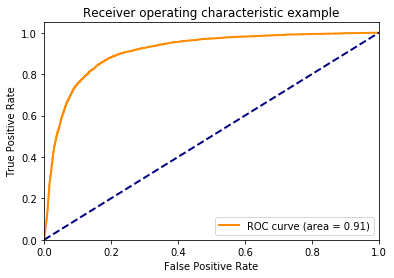

In [12]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

* #### Precision-Recall Curve

In [13]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_scores, pos_label=1)


In [14]:
from inspect import signature

from sklearn.metrics import average_precision_score

avg_precision = average_precision_score(y_true, y_scores)

print('Average precision-recall score: {0:0.2f}'.format(avg_precision))

Average precision-recall score: 0.91


Text(0.5, 1.0, 'User-Movie-rating Precision-Recall curve: AP=0.91')

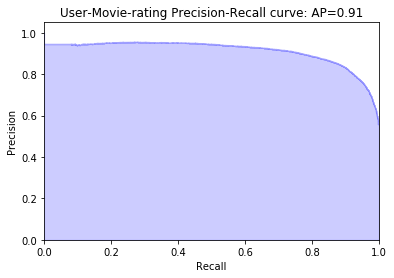

In [15]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('User-Movie-rating Precision-Recall curve: AP={0:0.2f}'.format(avg_precision))

* #### Creating confusion matrix

In [16]:
pred_arr['est']= pred_arr['est'].apply(lambda x:float(round(x)))
pred_arr.head(7)

,uid,iid,r_ui,est,details
0,861,242,1.0,1.0,{'was_impossible': False}
1,427,341,1.0,1.0,{'was_impossible': False}
2,417,90,0.0,0.0,{'was_impossible': False}
3,786,50,1.0,1.0,{'was_impossible': False}
4,346,455,0.0,0.0,{'was_impossible': False}
5,487,94,0.0,0.0,{'was_impossible': False}
6,277,100,1.0,1.0,{'was_impossible': False}


In [18]:
pred_arr= np.asarray(pred_arr)
np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==1)).shape[0]

9780

In [19]:
np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==0)).shape[0]

7132

In [20]:
np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==0)).shape[0]

1364

In [21]:
np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==1)).shape[0]

1724

In [22]:
def confusion_matrix(pred):
    pred_arr= pd.DataFrame(pred)
    pred_arr['est']= pred_arr['est'].apply(lambda x:float(round(x)))#changing prediction values to just 0s & 1s
    pred_arr= np.asarray(pred_arr)[:,:4]#contains first 4 cols of pred array, removing timestamp
    
    conf_df = pd.DataFrame(index=['True rating 1', 'True rating 0'], columns=['Estimated rating 1', 'Estimated rating 0'])
    
    conf_df['Estimated rating 1']['True rating 1']= np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==1)).shape[0]#True Positives, 9526
    conf_df['Estimated rating 0']['True rating 0']= np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==0)).shape[0]#True Negatives, 6822
    conf_df['Estimated rating 0']['True rating 1']= np.intersect1d(np.where(pred_arr[:, 2]==1), np.where(pred_arr[:, 3]==0)).shape[0]#False Negatives, 1470
    conf_df['Estimated rating 1']['True rating 0']= np.intersect1d(np.where(pred_arr[:, 2]==0), np.where(pred_arr[:, 3]==1)).shape[0]#False Positives, 2182
    
    return np.asarray(conf_df), conf_df

In [24]:
confusion_mat, confusion_df = confusion_matrix(pred)
confusion_df

,Estimated rating 1,Estimated rating 0
True rating 1,9780,1364
True rating 0,1724,7132


In [25]:
print(confusion_mat)

[[9780 1364]
 [1724 7132]]


* ### Training & testing results with SVD++ from surpirselib
    * Using same dataframes for both
    * n_factors= 100, epochs= 40

In [46]:
from surprise import SVDpp

t1= time.time()

algo_svdpp = SVDpp(n_factors=100, n_epochs=40)

algo_svdpp.fit(trainset)

print('training time:', time.time()-t1)


training time: 775.9093706607819


In [47]:
pred = algo_svdpp.test(testset)

print('\nTest results on 80k training data & 20k test data -- rmse:{}, mae:{}'.format(accuracy.rmse(pred), accuracy.mae(pred)))

RMSE: 0.3543
MAE:  0.2791

Test results on 80k training data & 20k test data -- rmse:0.35433296400534825, mae:0.2791093764734291


* ### Training & testing results with matrix factorization implemented with NN
    * Using same dataframes as above
    * Latent vector (k) size : 100, epochs =64

In [26]:
#print('new trimmed dataset:', sm_train_df.shape, '\nnew test dataset:', test_df.shape)

print('shape of dataset:', shuffled_df.shape)

shape of dataset: (100000, 4)


In [27]:
shuffled_df.head(5)

,0,1,2,3
54580,806,407,0,882386125
53189,614,147,1,879464332
46398,524,513,1,884634938
49861,153,172,0,881371140
82835,684,381,0,878762033


In [28]:
print('max value of user id:', max(shuffled_df[0]),'\nmax value of movie id:', max(shuffled_df[1]),'\nTherefore concatenated shape of input layer:',(max(shuffled_df[0])+max(shuffled_df[1]),))

max value of user id: 943 
max value of movie id: 1682 
Therefore concatenated shape of input layer: (2625,)


In [29]:
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.


In [30]:
x_train_user_in = to_categorical(shuffled_df[0])#contains the one-hot encoded user_id data, shaped (batch_size, max(sm_df[0]))
x_train_movie_in = to_categorical(shuffled_df[1])#contains the one-hot encoded movie_id data, shaped (batch_size, max(sm_df[1]))

y_ratings= shuffled_df[2]
print('shape of x_train_user_in:', x_train_user_in.shape,'\nshape of x_train_movie_in:', x_train_movie_in.shape,
      '\nshape of x_train_user_in:',y_ratings.shape)

shape of x_train_user_in: (100000, 944) 
shape of x_train_movie_in: (100000, 1683) 
shape of x_train_user_in: (100000,)


In [31]:
user_in_layer = Input(shape=(max(shuffled_df[0])+1,))#top half of input layer,+1 to accomodate on-hot encoded vectors
movie_in_layer = Input(shape=(max(shuffled_df[1])+1,))#bottom half of input layer

#total input moves as concatenated user_id & movie_id one-hot encoded forms

hid_layer_u = Dense(100)(user_in_layer)#latent dimension k=100 for user_id #_Embedding(100, )
hid_layer_m= Dense(100)(movie_in_layer)#latent dimension k=100 for movie_id

merge_layer = keras.layers.dot([hid_layer_u, hid_layer_m], axes=1)



predictions = Dense(1, activation='sigmoid')(merge_layer)

model = Model(inputs=[user_in_layer, movie_in_layer], outputs= predictions)

model.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 944)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1683)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          94500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          168400      input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [33]:
from keras.callbacks import ModelCheckpoint

checkpoints = ModelCheckpoint('./NN_m_factorization_weights.{epoch:02}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto', period=2)

In [71]:
??keras.callbacks.ModelCheckpoint

In [34]:
history = model.fit([x_train_user_in, x_train_movie_in], y_ratings, verbose=1, epochs=64, batch_size=32, validation_split=0.2, callbacks=[checkpoints])

Train on 80000 samples, validate on 20000 samples
Epoch 1/64
80000/80000 [==============================] - 5s 67us/step - loss: 0.6878 - mean_absolute_error: 0.4953 - acc: 0.5524 - val_loss: 0.6863 - val_mean_absolute_error: 0.4934 - val_acc: 0.5572
Epoch 2/64
80000/80000 [==============================] - 5s 66us/step - loss: 0.6869 - mean_absolute_error: 0.4940 - acc: 0.5528 - val_loss: 0.6859 - val_mean_absolute_error: 0.4939 - val_acc: 0.5572

Epoch 00002: val_loss improved from inf to 0.68592, saving model to ./NN_m_factorization_weights.02-0.69.hdf5
Epoch 3/64
80000/80000 [==============================] - 5s 64us/step - loss: 0.6863 - mean_absolute_error: 0.4938 - acc: 0.5528 - val_loss: 0.6852 - val_mean_absolute_error: 0.4935 - val_acc: 0.5572
Epoch 4/64
80000/80000 [==============================] - 5s 63us/step - loss: 0.6854 - mean_absolute_error: 0.4933 - acc: 0.5528 - val_loss: 0.6841 - val_mean_absolute_error: 0.4927 - val_acc: 0.5572

Epoch 00004: val_loss improved fro

80000/80000 [==============================] - 5s 62us/step - loss: 0.5215 - mean_absolute_error: 0.3516 - acc: 0.7417 - val_loss: 0.5500 - val_mean_absolute_error: 0.3624 - val_acc: 0.7167
Epoch 34/64
80000/80000 [==============================] - 5s 62us/step - loss: 0.5204 - mean_absolute_error: 0.3506 - acc: 0.7420 - val_loss: 0.5485 - val_mean_absolute_error: 0.3637 - val_acc: 0.7191

Epoch 00034: val_loss improved from 0.55069 to 0.54848, saving model to ./NN_m_factorization_weights.34-0.55.hdf5
Epoch 35/64
80000/80000 [==============================] - 5s 63us/step - loss: 0.5192 - mean_absolute_error: 0.3502 - acc: 0.7432 - val_loss: 0.5514 - val_mean_absolute_error: 0.3668 - val_acc: 0.7183
Epoch 36/64
80000/80000 [==============================] - 5s 63us/step - loss: 0.5183 - mean_absolute_error: 0.3499 - acc: 0.7431 - val_loss: 0.5482 - val_mean_absolute_error: 0.3622 - val_acc: 0.7193

Epoch 00036: val_loss improved from 0.54848 to 0.54824, saving model to ./NN_m_factoriza

In [35]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_acc', 'loss', 'mean_absolute_error', 'acc'])

* #### Training and Valdiation plots

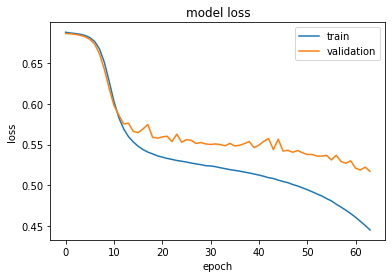

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')

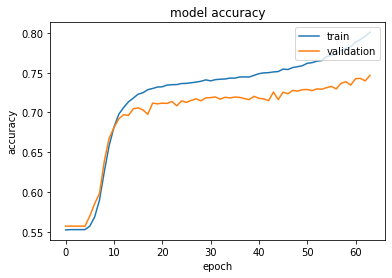

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend(['train', 'validation'], loc= 'upper right')

* ### Testing with individual cases

In [38]:
testcase = testset[np.random.randint(len(testset))]
print(testcase)

(268, 240, 1.0)


• **With SVD**

In [39]:
# int(testcase[2]>1) ;  because testset contains labels 0 in original df as 1 & 1 as 2
print('\nPredictions with SVD :\n', algo_svd.predict(testcase[0], testcase[1], int(testcase[2]>1), verbose=True))

user: 268        item: 240        r_ui = 0.00   est = 0.17   {'was_impossible': False}

Predictions with SVD :
 user: 268        item: 240        r_ui = 0.00   est = 0.17   {'was_impossible': False}


• **With SVD++** (Haven't retrained it for epochs=64)

In [54]:
print('\nPredictions with SVD++:\n', algo_svdpp.predict(testcase[0], testcase[1], testcase[2], verbose=True))

user: 716        item: 480        r_ui = 2.00   est = 0.97   {'was_impossible': False}

Predictions with SVD++:
 user: 716        item: 480        r_ui = 2.00   est = 0.97   {'was_impossible': False}


• **With NN factorization**

In [40]:
print('NN input layers shape requirement:\n')
model.input

NN input layers shape requirement:



[<tf.Tensor 'input_1:0' shape=(?, 944) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(?, 1683) dtype=float32>]

In [41]:
u_id = to_categorical(testcase[0], num_classes=int(model.input[0].shape[1]))
u_id= u_id.reshape((1,u_id.shape[0]))

item_id = to_categorical(testcase[1], num_classes=int(model.input[1].shape[1]))
item_id= item_id.reshape((1,item_id.shape[0]))

print('\nPredictions with NN matrix factorization:\n', model.predict(x= [u_id, item_id], verbose=True))

1/1 [==============================] - 0s 9ms/step

Predictions with NN matrix factorization:
 [[0.05117484]]


In [97]:
#from sklearn.model_selection import train_test_split

#array_data = np.asarray(shuffled_df)#changed df to numpy array

#new= np.append(to_categorical(array_data[:,0]), to_categorical(array_data[:,1]), axis=1) 
#data = array_data[:,:3]
#labels = array_data[:,2]

#x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.2, shuffle= True)

#x_train_user_in = to_categorical(x_train[:,0])#contains the one-hot encoded user_id data, shaped (batch_size, max(sm_df[0]))
#x_train_movie_in = to_categorical(x_train[:,1])#contains the one-hot encoded movie_id data, shaped (batch_size, max(sm_df[1]))

#y_train_ratings= y_train
#print('shape of x_train_user_in:', x_train_user_in.shape,'\nshape of x_train_movie_in:', x_train_movie_in.shape,
#      '\nshape of x_train_user_in:',y_train_ratings.shape)

# Split the data
#x_val_user_in = to_categorical(x_valid[:,0])#contains the one-hot encoded user_id data, shaped (batch_size, max(sm_df[0]))
#x_val_movie_in = to_categorical(x_valid[:,1])#contains the one-hot encoded movie_id data, shaped (batch_size, max(sm_df[1]))

#y_val_ratings= y_valid
#print('\n\nshape of x_val_user_in:', x_val_user_in.shape,'\nshape of x_val_movie_in:', x_val_movie_in.shape,
#      '\nshape of x_val_user_in:',y_val_ratings.shape)

shape of x_train_user_in: (80000, 944) 
shape of x_train_movie_in: (80000, 1683) 
shape of x_train_user_in: (80000,)


shape of x_val_user_in: (20000, 944) 
shape of x_val_movie_in: (20000, 1670) 
shape of x_val_user_in: (20000,)


In [79]:
#model.fit([x_train_user_in, x_train_movie_in], y_ratings, verbose=1, epochs=4, batch_size=32, validation_data=([x_train_user_in,x_train_movie_in],y_ratings))#validation_split=0.2)

Train on 100000 samples, validate on 100000 samples
Epoch 1/4
100000/100000 [==============================] - 8s 76us/step - loss: 0.6592 - mean_absolute_error: 0.4777 - acc: 0.6103 - val_loss: 0.6460 - val_mean_absolute_error: 0.4685 - val_acc: 0.6330
Epoch 2/4
100000/100000 [==============================] - 8s 76us/step - loss: 0.6304 - mean_absolute_error: 0.4565 - acc: 0.6538 - val_loss: 0.6119 - val_mean_absolute_error: 0.4425 - val_acc: 0.6764
Epoch 3/4
100000/100000 [==============================] - 8s 77us/step - loss: 0.5984 - mean_absolute_error: 0.4277 - acc: 0.6836 - val_loss: 0.5827 - val_mean_absolute_error: 0.4148 - val_acc: 0.6997
Epoch 4/4
100000/100000 [==============================] - 8s 77us/step - loss: 0.5761 - mean_absolute_error: 0.4040 - acc: 0.7006 - val_loss: 0.5664 - val_mean_absolute_error: 0.3969 - val_acc: 0.7102


* #### Therefore with 80k training datapoints & 20k validation datapoints after 64 epochs:
    * MAE value with surprise SVD implementation: 0.2746
    * MAE value with surprise SVD++ implementation: 0.3563
    * MAE value after 40 epochs with matrix factorization with NN implementation: 0.3149
    

